<a href="https://colab.research.google.com/github/spyysalo/consensus-pipeline/blob/master/ptm_ner_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NER experiment for PTM corpus annotation

In [1]:
!pip install --quiet transformers datasets evaluate seqeval

In [2]:
!mkdir -p ptm_ner
!wget -P ptm_ner -nc http://dl.turkunlp.org/ptm/ptm_ner.py

File ‘ptm_ner/ptm_ner.py’ already there; not retrieving.



In [3]:
from datasets import load_dataset


dataset = load_dataset('ptm_ner')

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 6543
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2285
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1600
    })
})

In [5]:
label_names = dataset['train'].features['ner_tags'].feature.names
num_labels = len(label_names)
id2label = { k: v for k, v in enumerate(label_names) }
label2id = { v: k for k, v in enumerate(label_names) }

In [6]:
!wget -nc https://dl.fbaipublicfiles.com/biolm/RoBERTa-base-PM-M3-Voc-train-longer-hf.tar.gz

File ‘RoBERTa-base-PM-M3-Voc-train-longer-hf.tar.gz’ already there; not retrieving.



In [7]:
!tar xzf RoBERTa-base-PM-M3-Voc-train-longer-hf.tar.gz

In [8]:
!ls RoBERTa-base-PM-M3-Voc-train-longer/RoBERTa-base-PM-M3-Voc-train-longer-hf

config.json  merges.txt  pytorch_model.bin  vocab.json


In [9]:
from transformers import AutoTokenizer


#MODEL = 'bert-base-cased'                      # f1 0.7089
#MODEL = 'emilyalsentzer/Bio_ClinicalBERT'      # f1 0.7362
#MODEL = 'dmis-lab/biobert-base-cased-v1.2'     # f1 0.7552
#MODEL = 'dmis-lab/biobert-base-cased-v1.1'     # f1 0.7714
#MODEL = 'dmis-lab/biobert-v1.1'                # f1 0.7758
#MODEL = 'dmis-lab/biobert-large-cased-v1.1'    # OOM
#MODEL = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'    # f1 0.8052
#MODEL = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract'             # f1 0.8372
MODEL = 'RoBERTa-base-PM-M3-Voc-train-longer/RoBERTa-base-PM-M3-Voc-train-longer-hf'    # f1 0.8378

if MODEL.startswith('RoBERTa'):
    tokenizer = AutoTokenizer.from_pretrained(MODEL, add_prefix_space=True)
else:
    tokenizer = AutoTokenizer.from_pretrained(MODEL)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Support functions from [transformers tutorial](https://huggingface.co/course/chapter7/2):

In [10]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:    # Start of a new word
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:          # Special token            
            new_labels.append(-100)
        else:                          # Same word as previous token
            label = labels[word_id]
            label_str = id2label[label]
            # If label is B-XXX we change it to I-XXX
            if label_str.startswith('B-'):
                label_str = 'I-'+label_str[2:]
                label = label2id[label_str]
            new_labels.append(label)
    return new_labels


def tokenize_and_align_labels(inputs):
    outputs = tokenizer(inputs['tokens'], truncation=True, is_split_into_words=True)
    new_labels = []
    for i, labels in enumerate(inputs['ner_tags']):
        word_ids = outputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    outputs['labels'] = new_labels
    return outputs

In [11]:
dataset = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/2285 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [12]:
from transformers import AutoModelForTokenClassification


model = AutoModelForTokenClassification.from_pretrained(
    MODEL,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at RoBERTa-base-PM-M3-Voc-train-longer/RoBERTa-base-PM-M3-Voc-train-longer-hf were not used when initializing RobertaForTokenClassification: ['lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at RoBERTa-base-PM-M3-Voc-train-longer/RoBERTa-base-PM-M3-Voc-train

From [transformers tutorial](https://huggingface.co/course/chapter7/2):

In [13]:
import evaluate


metrics = evaluate.load('seqeval')


def compute_metrics(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[i] for i in label if i != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metrics.compute(predictions=true_predictions, references=true_labels)
    return {
        'precision': all_metrics['overall_precision'],
        'recall': all_metrics['overall_recall'],
        'f1': all_metrics['overall_f1'],
        'accuracy': all_metrics['overall_accuracy'],
    }

In [14]:
from collections import defaultdict

from transformers import TrainerCallback


class LogSavingCallback(TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

In [15]:
from transformers import TrainingArguments


trainer_args = TrainingArguments(
    output_dir='checkpoints',
    evaluation_strategy='steps',
    logging_strategy='steps',
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=0.00002,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    max_steps=1500,
)

In [16]:
from transformers import Trainer, DataCollatorForTokenClassification


data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[training_logs], 
)

max_steps is given, it will override any value given in num_train_epochs


In [17]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: tokens, id, ner_tags. If tokens, id, ner_tags are not expected by `RobertaForTokenClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6543
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1500
  Number of trainable parameters = 123864585
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` 

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,0.417300,0.184187,0.719639,0.737422,0.728422,0.946226
200,0.149000,0.154532,0.753074,0.816533,0.783521,0.954533
300,0.127200,0.144252,0.766574,0.836622,0.800068,0.958044
400,0.119300,0.128131,0.769942,0.828800,0.798288,0.960547
500,0.081600,0.143838,0.764245,0.848889,0.804346,0.960086
600,0.077200,0.133911,0.799865,0.844800,0.821719,0.961904
700,0.069700,0.133876,0.798392,0.847644,0.822282,0.961260
800,0.081200,0.128081,0.799667,0.854400,0.826128,0.963064
900,0.055100,0.141240,0.813662,0.855467,0.834041,0.963106
1000,0.053900,0.132049,0.806988,0.854044,0.829850,0.963344


The following columns in the evaluation set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: tokens, id, ner_tags. If tokens, id, ner_tags are not expected by `RobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2285
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: tokens, id, ner_tags. If tokens, id, ner_tags are not expected by `RobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2285
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: tokens, id, ner_tags. If tokens, id, ner_tags are not expected by `RobertaForTokenClassification.forward`,  you can safely ignore th

TrainOutput(global_step=1500, training_loss=0.09640466578801472, metrics={'train_runtime': 535.4801, 'train_samples_per_second': 44.82, 'train_steps_per_second': 2.801, 'total_flos': 822253410435294.0, 'train_loss': 0.09640466578801472, 'epoch': 3.67})

In [18]:
eval_results = trainer.evaluate(dataset['test'])

print(eval_results)

The following columns in the evaluation set don't have a corresponding argument in `RobertaForTokenClassification.forward` and have been ignored: tokens, id, ner_tags. If tokens, id, ner_tags are not expected by `RobertaForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 32


{'eval_loss': 0.11921289563179016, 'eval_precision': 0.8200256739409499, 'eval_recall': 0.8565299007776884, 'eval_f1': 0.8378803777544596, 'eval_accuracy': 0.9672465316946703, 'eval_runtime': 7.9936, 'eval_samples_per_second': 200.161, 'eval_steps_per_second': 6.255, 'epoch': 3.67}


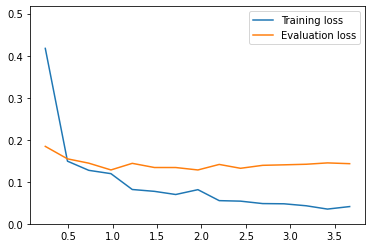

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):    
        plt.plot(logs['epoch'], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ['loss', 'eval_loss'], ['Training loss', 'Evaluation loss'])

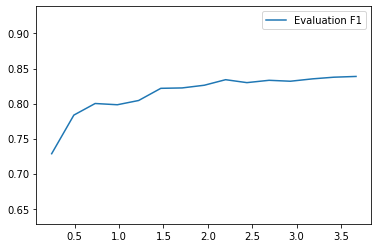

In [20]:
plot(training_logs.logs, ['eval_f1'], ['Evaluation F1'])

In [21]:
from transformers import pipeline


pipe = pipeline(
    'ner',
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy='simple',
    device=0
)

In [22]:
def tag(text):
    output = pipe(text)
    print('input:', text)
    print('output:', [(o['word'], o['entity_group']) for o in output])

In [23]:
tag('The cysteine-rich sprouty translocation domain targets mitogen-activated protein kinase inhibitory proteins to phosphatidylinositol 4,5-bisphosphate in plasma membranes.')

input: The cysteine-rich sprouty translocation domain targets mitogen-activated protein kinase inhibitory proteins to phosphatidylinositol 4,5-bisphosphate in plasma membranes.
output: [(' sprouty', 'Protein'), (' mitogen-activated protein kinase inhibitory', 'Family'), (' phosphatidylinositol 4,5-bisphosphate', 'Chemical')]
